In [3]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import os
from IPython import display
import warnings
warnings.filterwarnings('ignore')

import jqdatasdk as jq

# 请在环境变量中设置聚宽账号。账号可在jointquant.com上免费申请
account = os.environ.get('JQ_ACCOUNT')
password = os.environ.get('JQ_PASSWORD')
jq.auth(account, password)
securities = jq.get_all_securities()

尽管量化交易是机器执行的，我们仍然需要将数据可视化。比如，在使用CNN网络之前，我们需要把行情数据处理成图像数据（比如K线图）；也有可能你调制了一个绝妙的指标，能够很好地发现买卖点--但是眼见为实，这么好的指标，你最好是把它标注在K线图上，人工复核几遍才能够放心。

与交易相关的图中，可能最复杂的就是K线图了。对非定制化的、交互式的K线图，我们可以直接使用Pyecharts来绘制：

In [222]:
import pyecharts

import numpy as np
from pyecharts import options as opts
from pyecharts.charts import Line, Kline, Bar


def moving_average(ts, win):
    return np.convolve(ts, np.ones(win)/win, 'valid')

def left_padding(arr, count, obj = None):
    padded = [obj] * count
    padded.extend(arr)

    return padded

fields = ['date', 'open', 'high', 'low', 'close', 'volume']
bars = jq.get_bars('000001.XSHG', 60, unit='1d', df=False, fields=fields)

# data must be sequence of int, float, str or other simple object
ochl = [list(item) for item in bars[['open', 'close', 'high', 'low']]]

# datetime object is not supported
dt = [str(d) for d in bars['date']]


mas = {}
for win in [5, 10, 20]:
    # 对均线数据，向左填充None，使得它们在绘制时能对齐k线
    mas[f"ma{win}"] = left_padding(moving_average(bars['close'], win),
                                   win, None)
    
k = (
    Kline()
    .add_xaxis(dt)
    .add_yaxis('kline', ochl)
    .set_global_opts(
        yaxis_opts=opts.AxisOpts(is_scale=True),
        xaxis_opts=opts.AxisOpts(is_scale=True),
        title_opts=opts.TitleOpts(title="K线图"),
        datazoom_opts=[opts.DataZoomOpts()]
    )
)

for win in [5, 10, 20]:
    name = f"ma{win}"
    data = mas[name]
    line = Line()
    line.add_xaxis(dt)
    line.add_yaxis(name, data,
                   label_opts=opts.LabelOpts(is_show=False),
                   is_symbol_show=False)

    k.overlap(line)
    
# clean up PendingDeprecationWarning by pyechart
display.clear_output()

# 显示在notebook的cell中。如果要生成网页，一般调用render()
k.render_notebook()


但在量化交易中，我们并不太需要上面这种交互式的K线图。特别是在为神经网络训练准备可视化数据时，我们很可能并不想使用传统的K线图，而是自己定制的某种图。另外，作为探索式编程的一部分，我们常常需要在jupyter notebook中把指标和方案可视化。因此，我们需要掌握一些基本的绘图知识。

下面，我们就以matplot绘图为例，介绍相关的绘制知识。

您可能已经注意到，在各章节配套的notebook开头，我们都有这样的语句：

In [6]:
%matplotlib inline

import matplotlib.pyplot as plt

在前面几章里，我们的进度有点快，这里我们放慢一点速度，对一些细节多提几句。

第一行是jupyter notebook魔法，它使得我们通过matplotlib.pyplot绘制的图形可以在notebook中的cell中显示出来。与之对应的，在pyechart，我们则是调用render_notebook来实现的。

第二行是导入matplot的python实现库pyplot。前面我们使用了pyplot中的这些方法：

/home/userroot/miniconda3/envs/alpha/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


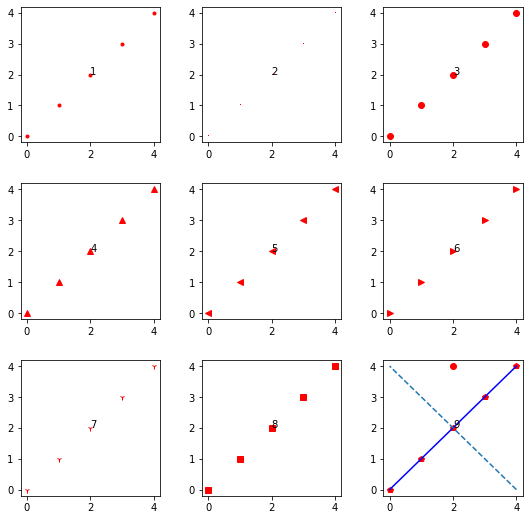

In [42]:
# 指定绘图区的大小。这里figsize是一个元组，分别指定绘图区
# 的宽和高（inch单位)。如果dpi设置为80的话，则下面的语句
# 指定了一个宽720,高720的绘图区

plt.figure(figsize=(9,9))

# 设置子绘图时使用的窗格，必须为一个三位的数字，第一位是
# 行数，第二位是列数，第三位是子图窗格的索引，起始值为1
# 下面的语句绘制了一个九宫格，并在图正中指定了其子图索引

#     ``'.'``          point marker
#     ``','``          pixel marker
#     ``'o'``          circle marker
#     ``'v'``          triangle_down marker
#     ``'^'``          triangle_up marker
#     ``'<'``          triangle_left marker
#     ``'>'``          triangle_right marker
#     ``'1'``          tri_down marker
#     ``'2'``          tri_up marker
#     ``'3'``          tri_left marker
#     ``'4'``          tri_right marker
#     ``'s'``          square marker
#     ``'p'``          pentagon marker
#     ``'*'``          star marker
#     ``'h'``          hexagon1 marker
#     ``'H'``          hexagon2 marker
#     ``'+'``          plus marker
#     ``'x'``          x marker
#     ``'D'``          diamond marker
#     ``'d'``          thin_diamond marker
#    ``'|'``          vline marker
marks = ['.',',','o','^','<','>','1','s','p','*']

for i in range(1, 10):
    plt.subplot(int(f"33{i}"))
    # 绘制文字
    plt.text(2,2, str(i))
    # 绘制标记
    plt.plot(np.arange(5), np.arange(5), marks[i-1], color='r')
    
# 当前指定的子图仍为第9号子图。在其上绘制实线line
plt.plot(np.arange(5), np.arange(5), color='b')

# 绘制虚拟line
plt.plot(np.arange(5)[::-1], np.arange(5), '--')

# 给子图之间增加间距
plt.subplots_adjust(hspace=0.3, wspace=0.3)

如果不指定子图，则会当成只有一个子图的情况。以上就是我们之前使用过的全部绘图方法。下面，我们来看应该如何绘制k线图。

K线（蜡烛）图是由一个实体和上下影线组成的。我们使用矩形(Rectangle对象）来绘制实体，线（Line2D)来绘制上下影线。绘制实际上很简单，只要给这些矩形和上下影线指定好参数，再添加到图形中就可以了。

In [291]:
from matplotlib.collections import LineCollection, PatchCollection
from matplotlib.lines import Line2D
from matplotlib.patches import Rectangle
def candle_stick_plot(ax, bars, bw:float=0.6, lw:float=0.4, ma_groups=None):
    # 上影线顶点坐标
    vertex_top = np.zeros((len(bars), 2, 2))
    # 下影线顶点坐标
    vertex_bottom = np.zeros((len(bars), 2, 2))
    
    rects = []

    # 线和实体边框的颜色
    edge_color = np.where(bars['close']>=bars['open'],'r', 'g')
    # 实体的颜色，这里指定为白色，从而显示为空心矩形
    face_color = ['w'] * len(bars)
    
    for i in range(len(bars)):
        o,c,l,h = bars[i][['open', 'close', 'low', 'high']]
        # 计算各上影线、下影线的绘制坐标
        xi = i - lw/2.0
        if o >= c:
            vertex_top[i] = [[xi, o], [xi, h]]
            vertex_bottom[i] = [[xi, l], [xi, c]]
        else:
            vertex_top[i] = [[xi, c], [xi, h]]
            vertex_bottom[i] = [[xi, l], [xi, o]]

        # 设置K线实体矩形的参数
        rect = Rectangle((i - bw/2.0 - lw/2.0, min(bars[i]['close'], 
                        bars[i]['open'])),width=bw, lw=lw, 
                          height=abs(bars[i]['open']-bars[i]['close']))
        
        rects.append(rect)

    for vertex in [vertex_top, vertex_bottom]:
        line_collection = LineCollection(vertex, color=edge_color,linewidths=lw)
        ax.add_collection(line_collection)

    rect_pc = PatchCollection(rects, facecolor=face_color, edgecolor=edge_color)
    ax.add_collection(rect_pc)
    
    # 叠加均线
    for i, win in enumerate(ma_groups or []):
        ma = moving_average(bars['close'], win)
        ma = left_padding(ma, win-1, None)
        line = Line2D(np.arange(len(ma)), ma, color=f"C{i}", linewidth=lw)
        ax.add_line(line)
    
    # 设置x,y轴显示范围
    ax.set_ylim(min(bars['close'])*0.99, max(bars['close'])*1.01)
    ax.set_xlim(-1, len(bars)+1)
    
    # 隐藏下边的x轴标签
    ax.xaxis.set_tick_params(length=0)
    ax.xaxis.set_tick_params(labelbottom=False)


In [292]:
def draw_volume_bars(ax, bars, bw:float=0.6):
    ax.bar(np.arange(len(bars)), bars['volume'], color=np.where(bars['close']>=bars['open'], 'r', 'g'), width=bw)
    ax.set_xlim(-1, len(bars)+1)
    ax.set_ylim(min(bars['volume'])*0.99, max(bars['volume']) * 1.01)
    ax.spines["top"].set_visible(False)

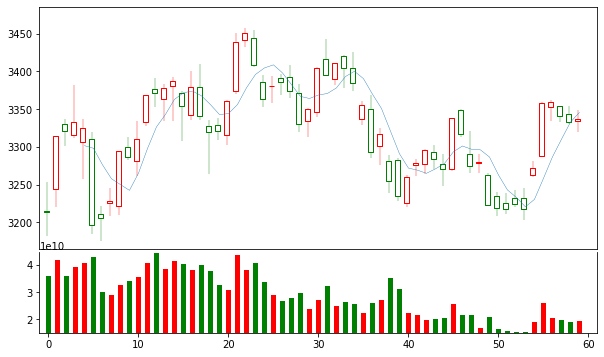

In [304]:
fig, (kax, vax) = plt.subplots(2,1,gridspec_kw={'height_ratios':[3,1]},figsize=(10,6))
plt.subplots_adjust(hspace=0.02)
candle_stick_plot(kax, bars, ma_groups=[5])
draw_volume_bars(vax, bars)

这里出现了新的对象，即轴(ax)对象。到现在为止，我们见过了五个容易混淆的概念：plt, subplot, subplots, figure和ax。图上的每一个点和线，最终都是绑定到具体的轴(ax)的，每个ax下面还有xaxis和yaxis对象，但它们就不再拥有点、线这些绘图元素了。plt只是名字空间，它不拥有任何绘图元素；figure是绘图用的抽象画布，它下面有ax对象（即前面所说的子图）。subplot则是一个方法，用来指定当前使用哪一个子图(ax)来绘图。

关于fig与ax的关系，我们可以参考下图：

![](https://matplotlib.org/1.5.1/_images/fig_map.png)

当我们调用plt.plot时，并没有指定任何特别的对象；pyplot在背后指定了一个全局的figure，它有一个子图对象(ax)。所以，我们可以这样创建fig和子图：

In [ ]:
# 创建并返回两个ax对象
fig, (kax, vax) = plt.subplots(2,1)

也可以这样：

In [ ]:
fig, ax = plt.subplots()

这里只创建并返回了一个ax对象。

在上面的代码中，使用了LineCollection和PathCollection，这是性能优化的方法之一。上面的代码还有可以优化的地方，比如生成上下影线和实体矩形参数，是可以使用numpy来避免循环的。

但这里真正的瓶颈是matplotlib本身。在我的笔记本电脑上，类似于上面的K线图，它每秒只能生成2~3幅。与之相比，我们上面提到的优化循环部分就显得无足轻重了。因为这个原因，为了易读性考虑，我保留了代码中的循环。

如果只是为了进行一些探索，上面的函数提供的性能是能满足需要的；但当我们使用CNN来训练和预测交易时，上面的函数就显得力不从心了。那时候我们必须得寻求60fps以上的方案。这个性能其实并不难，只要使用opengl，就能轻松达到。

如果我们需要保存图像到文件，我们需要使用 _figure.savefig_ 方法：

In [306]:
save_to  = '/tmp/test.png'
fig.savefig(save_to, dpi = 80)

如果我们需要进一步处理图像数据，可以使用BytesIO来把图像直接读到内存：

In [308]:
from io import BytesIO

buf = BytesIO()
# 此时必须指定format
fig.savefig(buf, format='png')
# 必须，否则buf无法读出
buf.seek(0)

0